<a href="https://colab.research.google.com/github/lathigamohan/Veracity-Vigilance/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING** **DATASET:** + saving the dataset


In [3]:
import pandas as pd
import os
import kagglehub
dataset_path = kagglehub.dataset_download('jainpooja/fake-news-detection')
print("Files in dataset folder:")
print(os.listdir(dataset_path))

100%|██████████| 41.0M/41.0M [00:00<00:00, 207MB/s]

Extracting files...


Files in dataset folder:
['True.csv', 'Fake.csv']


In [4]:
fake_path = os.path.join(dataset_path, "Fake.csv")
real_path = os.path.join(dataset_path, "True.csv")

df_fake = pd.read_csv(fake_path)
df_real = pd.read_csv(real_path)

print(" Fake News shape:", df_fake.shape)
print(" Real News shape:", df_real.shape)

 Fake News shape: (23481, 4)
 Real News shape: (21417, 4)


IMPORTING REQUIRED LIBRARIES

In [5]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Label and combine the datasets

In [7]:
df_fake['label'] = 0
df_real['label'] = 1
df = pd.concat([df_fake, df_real], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("labeled")

labeled


**CLEAN THE** **DATASET**

In [9]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
print("dataset was cleaned")

dataset was cleaned


# **VISUALIZATIONS**

***1. Fake vs Real Count***

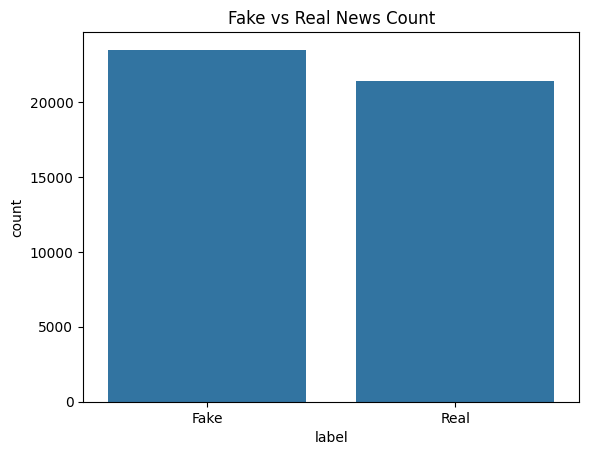

In [10]:
sns.countplot(x='label', data=df)
plt.title("Fake vs Real News Count")
plt.xticks([0,1], ['Fake','Real'])
plt.show()

2. ***WordClouds***

In [11]:
fake_words = ' '.join(df[df.label==0]['cleaned_text'])
real_words = ' '.join(df[df.label==1]['cleaned_text'])

WordCloud(width=800, height=400, background_color='black').generate(fake_words).to_image().show()
WordCloud(width=800, height=400, background_color='white').generate(real_words).to_image().show()

***3 . Lenght of text***

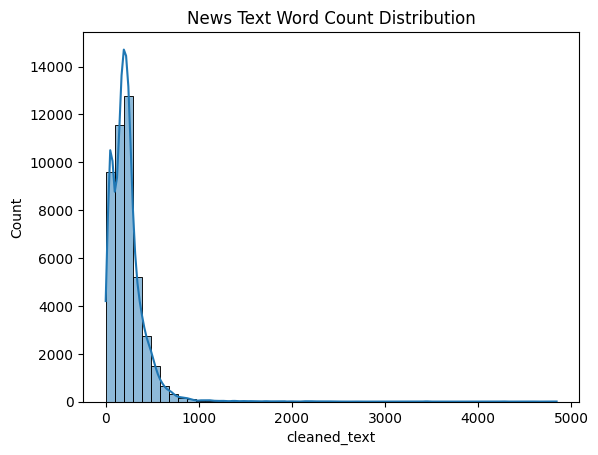

In [12]:
sns.histplot(df['cleaned_text'].apply(lambda x: len(x.split())), bins=50, kde=True)
plt.title("News Text Word Count Distribution")
plt.show()

# **TF-IDF Feature Engineering**

In [13]:
X = df['cleaned_text']
y = df['label']

vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X)

Train-Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

Train Classifier

In [15]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

Evaluation

In [16]:
y_pred = model.predict(X_test)
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))


 Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4710
           1       0.98      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Confusion Matrix

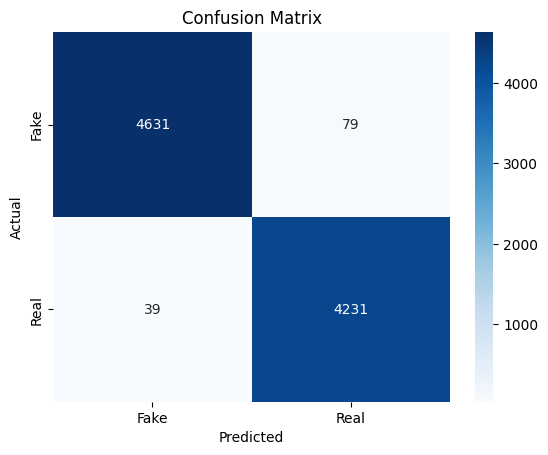

In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **Custom** **News Prediction**

In [20]:
def predict_news(news_text):
    cleaned = clean_text(news_text)
    vector = vectorizer.transform([cleaned])
    pred = model.predict(vector)[0]
    return "REAL News " if pred == 1 else "FAKE News "


In [21]:
sample = "Breaking: Aliens Land in Tamil Nadu and Start Teaching AI"
print("\n Prediction:", predict_news(sample))


 Prediction: FAKE News 


# **USER** **INPUTS**

In [22]:
news_input = input("Enter your news article to check if it's real or fake:\n")
print(" Prediction:", predict_news(news_input))

Enter your news article to check if it's real or fake:
I found a bacteria-eating virus in my loo - could it save your life?
 Prediction: FAKE News 


In [48]:
from IPython.display import display
import ipywidgets as widgets

news_widget = widgets.Textarea(
    value='',
    placeholder='Type or paste a news article here...',
    description='News:',
    layout=widgets.Layout(width='80%', height='120px')
)
display(news_widget)


Textarea(value='', description='News:', layout=Layout(height='120px', width='80%'), placeholder='Type or paste…

Confidence score of news prediction with visualization


 Prediction: FAKE News 
 Confidence: 92.38% vs Real : 7.62%


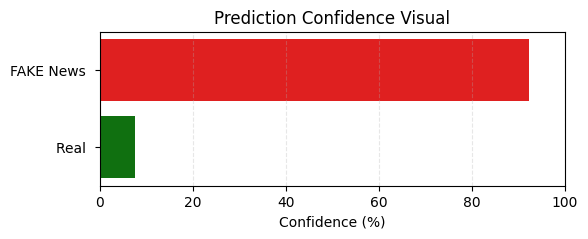

In [55]:
def show_prediction_with_chart(news_text):
    cleaned = clean_text(news_text)
    vector = vectorizer.transform([cleaned])
    pred_proba = model.predict_proba(vector)[0]
    label = model.predict(vector)[0]
    confidence = round(pred_proba[label] * 100, 2)
    other_conf = round(pred_proba[1 - label] * 100, 2)

    result_label = 'REAL News ' if label == 1 else 'FAKE News '
    alt_label = 'Fake ' if label == 1 else 'Real '
    print(f"\n Prediction: {result_label}")
    print(f" Confidence: {confidence}% vs {alt_label}: {other_conf}%")
    labels = [result_label, alt_label]
    values = [confidence, other_conf]
    colors = ['green', 'red'] if label == 1 else ['red', 'green']

    plt.figure(figsize=(6, 2))
    sns.barplot(x=values, y=labels, palette=colors)
    plt.xlim(0, 100)
    plt.xlabel("Confidence (%)")
    plt.title("Prediction Confidence Visual")
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.show()
user_news = news_widget.value
show_prediction_with_chart(user_news)
